# Importing Libraries

In [1]:
import os
import re
import cv2
import datetime
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

1. # Dataset Loading and preprocessing

### Combining all annotations into a single

In [6]:
target_classes = ['go', 'stop', 'warning']
DAY_TRAIN_PATH = 'archive/Annotations/Annotations/dayTrain/'
train = []
for clipName in tqdm(sorted(os.listdir(DAY_TRAIN_PATH))):
    # if 'dayClip' not in clipName:
    #     continue
    df = pd.read_csv(os.path.join(DAY_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    df['Filename'] = df['Filename'].apply(lambda filename: re.findall("\/([\d\w-]*.jpg)", filename)[0])
    df['image_path'] = 'archive/dayTrain/dayTrain/' + clipName + '/frames/' + df['Filename']
    train.append(df)

df = pd.concat(train,axis=0)
df = df[df['Annotation tag'].isin(target_classes)]
df = df.drop(['Origin file', 'Origin frame number', 'Origin track', 'Origin track frame number'], axis=1)
df.columns = ['filename', 'label', 'x1', 'y1', 'x2', 'y2', 'image_id']
df.label = pd.Categorical(df.label)
df = df.drop_duplicates().reset_index(drop=True)


  0%|          | 0/13 [00:00<?, ?it/s]

In [7]:
df['label'].value_counts()
# df['target'].value_counts(normalize=True)

label
stop       15113
go         13830
warning      755
Name: count, dtype: int64

### Visualizing Dataset

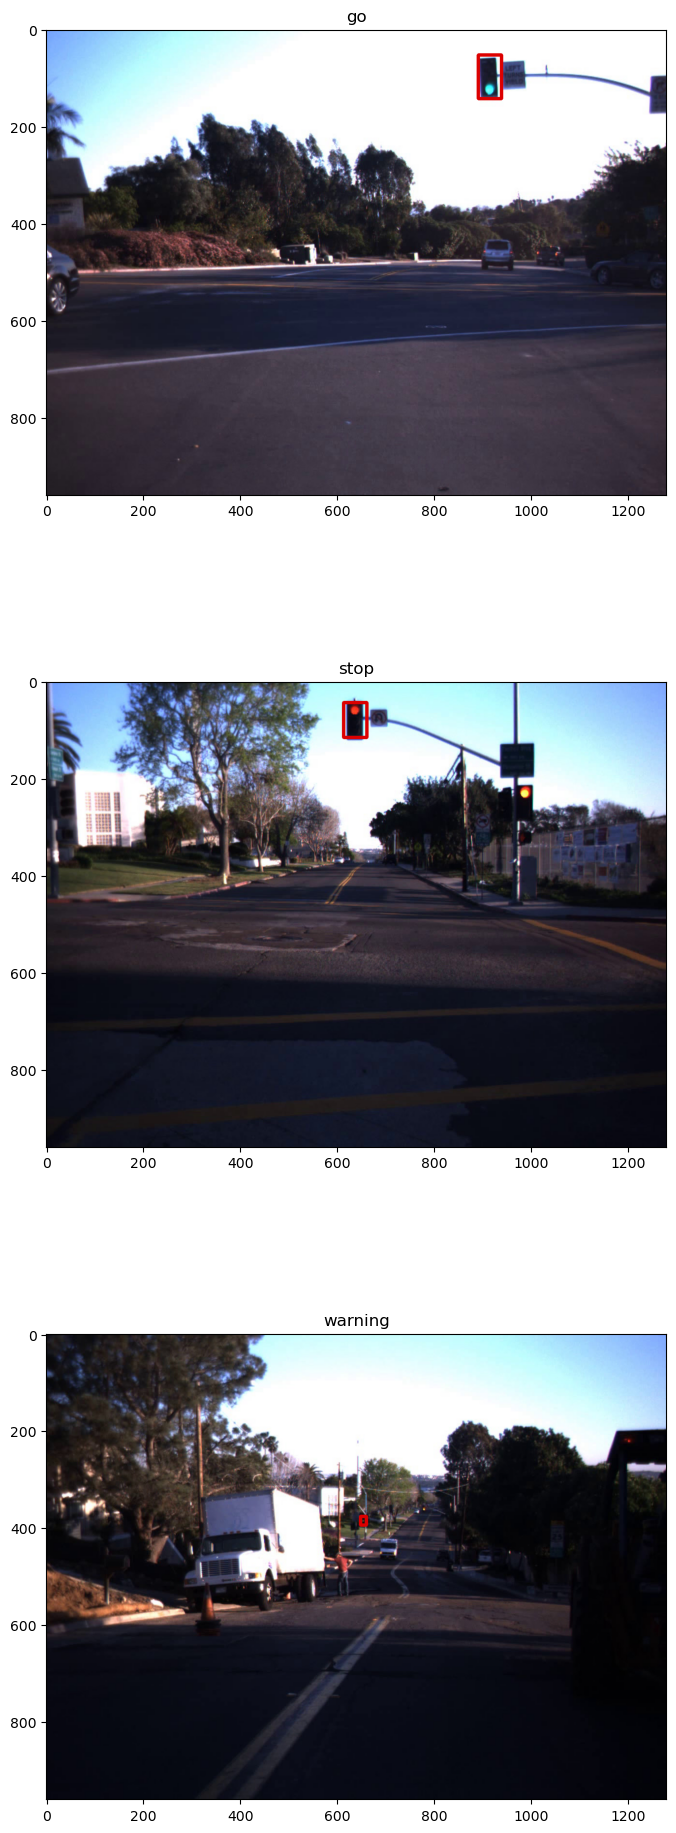

In [8]:
fig, ax = plt.subplots(len(target_classes),1,figsize=(8,8*len(target_classes)))
for i, tag in enumerate(target_classes):
    sample = df[df['label']==tag].sample(1,)
    bbox = sample[['x1','y1','x2','y2']].values[0]
    image = cv2.imread(sample.image_id.values[0])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(220, 0, 0), 5)
    ax[i].set_title(tag)
    # ax[i].set_axis_off()
    ax[i].imshow(image)

### Preprocessing and splitting

In [9]:
# Create a new column for splitting
df['clipNames'] = df[['image_id']].applymap(lambda x: x.split('/')[5])

IndexError: list index out of range

In [ ]:
def split(df,frac=0.2):
    clipNames = sorted(df['clipNames'].unique())

    nightClips = [name for name in clipNames if 'night' in name]
    dayClips = [name for name in clipNames if 'day' in name]

    testNightClipNames = list(np.random.choice(nightClips,int(len(nightClips)*frac)))
    testDayClipNames = list(np.random.choice(dayClips,int(len(dayClips)*frac)))
    testClipNames = testNightClipNames + testDayClipNames

    trainDayClipNames = list(set(dayClips) - set(testDayClipNames))
    trainNightClipNames = list(set(nightClips) - set(testNightClipNames))
    trainClipNames = trainNightClipNames + trainDayClipNames

    train_df = df[df.clipNames.isin(trainClipNames)]
    test_df = df[df.clipNames.isin(testClipNames)]

    return train_df, test_df

In [ ]:
train_df, test_df = split(df)
train_df, val_df = split(train_df)
train_df

# Creating dataset pipeline for model

In [ ]:
# To create custom dataset format for fastercnn training
class TLDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        super().__init__()
        self.image_ids = df.image_id.unique()
        self.df = df
        self.transforms = transforms

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        records = self.df[self.df.image_id == image_id]

        # Reading Image
        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        # Bounding Boxes
        boxes = records[['x1','y1','x2','y2']].values
        boxes = torch.as_tensor(boxes,dtype=torch.float32)

        # Area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Labels of the object detected
        labels = torch.as_tensor(records.label.astype('category').cat.codes.values, dtype=torch.int64)
        # suppose all instances are not crowd
        iscrowd = torch.zeros_like(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        # target["masks"] = masks
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.as_tensor(sample['bboxes'],dtype=torch.float32)
            target['labels'] = torch.as_tensor(sample['labels'])

        return image, target

    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
# Albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
def Transform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        # A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
val_df

In [ ]:
trainDataset = TLDataset(train_df, Transform())
valDataset = TLDataset(val_df, Transform())
testDataset = TLDataset(test_df, Transform())

In [ ]:
trainDataLoader = DataLoader(
    trainDataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)
valDataLoader = DataLoader(
    valDataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)
testDataLoader = DataLoader(
    testDataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

## Checking if data is loading properly

In [ ]:
images, targets = next(iter(trainDataLoader))
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
image = images[0].permute(1,2,0).cpu().numpy()

In [ ]:
def displayImage(image, boxes):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()

displayImage(image,boxes)

# Utility Functions

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, '/kaggle/working/last_model.pth')
def save_loss_plot(OUT_DIR, train_loss, val_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    train_ax.plot(train_loss, color='tab:blue')
    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss, color='tab:red')
    valid_ax.set_xlabel('iterations')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(f"{OUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUT_DIR}/valid_loss.png")
    print('SAVING PLOTS COMPLETE...')
    plt.close('all')

In [ ]:
import matplotlib.pyplot as plt
import time
plt.style.use('ggplot')

In [ ]:
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list

     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [ ]:
# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

# Model training

## loading fastercnn on resnet50

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
N_CLASS = 4
INP_FEATURES = model.roi_heads.box_predictor.cls_score.in_features

# New Head for Classification
model.roi_heads.box_predictor = FastRCNNPredictor(INP_FEATURES, N_CLASS)

In [ ]:
# move model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
device

In [ ]:
 # get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)


In [ ]:
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

# name to save the trained model with
MODEL_NAME = 'model'

In [ ]:
NUM_EPOCHS=3
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(trainDataLoader, model)
    val_loss = validate(valDataLoader, model)
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
    # save the current epoch model
    save_model(epoch, model, optimizer)

    # save loss plot
    save_loss_plot('/kaggle/working/', train_loss, val_loss)

In [ ]:
# save_loss_plot('/kaggle/working/', train_loss, val_loss)

In [ ]:
# !git clone https://github.com/pytorch/vision.git
# !cd vision
# !git checkout v0.15.1

!cp /kaggle/working/vision/references/detection/utils.py .
!cp /kaggle/working/vision/references/detection/transforms.py .
!cp /kaggle/working/vision/references/detection/coco_eval.py .
!cp /kaggle/working/vision/references/detection/engine.py .
!cp /kaggle/working/vision/references/detection/coco_utils.py .

In [ ]:
!pip install pycocotools

In [ ]:
from engine import evaluate
evaluate(model, testDataLoader, device=device)

# Visualizing Predictions on test dataset

In [ ]:
# pick one image from the test set
img, _ = testDataset[2000]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
prediction

In [ ]:
color_map = {3:'go', 1:'stop', 2:'warning'}
color_coding = {3: (0, 255, 0), 1: (255, 0, 0), 2: (255, 255, 0)}
labels = prediction[0]['labels'].cpu().numpy().astype(np.int32)
boxes = prediction[0]['boxes'].cpu().numpy().astype(np.int32)
image = img.permute(1,2,0).cpu().numpy()